# Train a video embedding model

A "video embedding model" is a function that maps video clips to a high-dimensional feature space. The embeddings can then be used for downstream tasks such as clustering or supervised behavior classification. This tutorial includes the following steps:

1. [Optional] crop videos around the subject of interest
2. Set up data loading and augmentation
3. Fit the embedding model using [Barlow Twins](https://arxiv.org/abs/2103.03230)
4. Inspect embeddings for a random sample of video clips

This tutorial uses an [example dataset](https://www.dropbox.com/scl/fo/habb4oa7pgms012amnynu/AFTDSfk-x6wgNI0fbSjJIwc?rlkey=g06de47y5kpu6ds5sxqwwpfr7&dl=0) with 4 videos of mice engaged in nest-building.


In [11]:
import video_embedding as ve
import matplotlib.pyplot as plt
import albumentations as A
from scipy.ndimage import gaussian_filter1d, median_filter
from torch.utils.data import DataLoader
from datetime import datetime
import numpy as np
import pandas as pd
import torch
import tqdm
import cv2
import os

## 1. [Optional] crop videos around the subject of interest

We recommend cropping videos around the subject animal to speed up training and highlight relevant aspects of the video. 
- For multianimal videos, we recommend cropping around one animal or limiting the input data to times when the animals are close together.
- This step requires tracking the animal(s) in each video. For now, users must supply their own tracking data. A separate tracking tutorial is in development. 

### Load tracking data

In the example dataset, each video is paired with a `*.track.npy` file containing the mouse's centroid at each timepoint. 
```
    example_data
    ├──video1.mp4
    ├──video1.track.npy
    ├──video2.mp4
    ├──video2.track.npy
    ⋮
```
These files are loaded into a dictionary that maps video paths to tracks. **Note: although the pipeline does not require any specific file organization, a dictionary with this format is required for the next set of steps.**

In [2]:
# List paths to example videos (adjust as necessary)
video_paths = [f"example_data/video{i}.mp4" for i in range(1,5)]

# Load centroids
tracks = {}
for video_path in video_paths:
    track_path = video_path.replace(".mp4", ".track.npy")
    tracks[video_path] = np.load(track_path)

### Choose a crop size
Two rounds a cropping are performed during model training. First, videos are preprocessed using an "outer crop size", which helps speed up video-reading operations. Video clips are then cropped a second time using an "inner crop size" before being fed to the model. The outer crop size should be 1.3 - 1.5 times bigger than the inner crop size to so that clips can be translated and rotated during model training without significant border artifacts. The code below shows what the selected crop sizes look like in a random sample of frames. Adjust as necessary for your own data. **Note: the outer crop size should be divisible by 16 to prevent resizing during video encoding**.

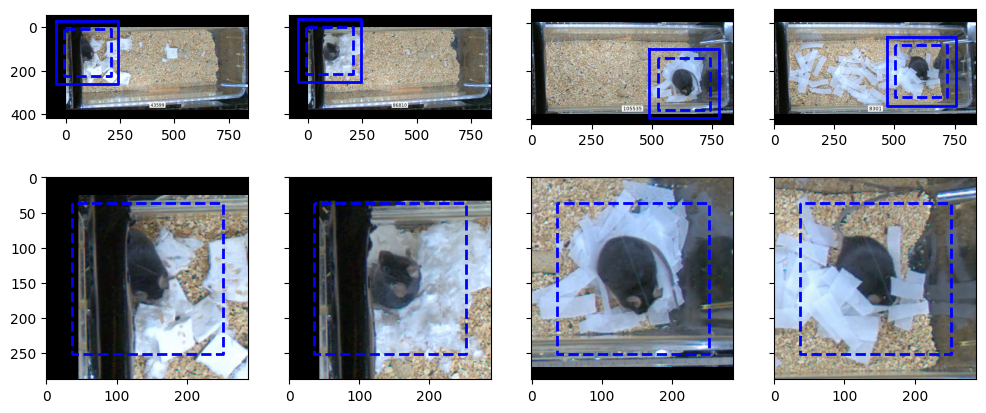

In [3]:
outer_crop_size = 288 # this is used for preprocesing the videos
inner_crop_size = 216 # this is the final size that will be used for video embedding (can be changed later)

fig = ve.inspect_crop_sizes(tracks, inner_crop_size, outer_crop_size)
fig.set_size_inches((12,5.5))
fig.subplots_adjust(hspace=0)

### Smooth tracking data
To avoid jitter and/or outlier frames, it's important to smooth the tracking data. In the code below, a median filter is used to remove outliers and then a Gaussian filter is used for overall smoothing.


In [4]:
median_kernel_size = 61  # corresponds to ~2 seconds for the example data
gaussian_kernel_size = 15 # corresponds to 0.5 seconds for the example data

smooth_tracks = {}
for video_path, track in tracks.items():
    track = median_filter(track, (median_kernel_size, 1))
    track = gaussian_filter1d(track, gaussian_kernel_size, axis=0)
    smooth_tracks[video_path] = track

### Crop videos

Cropped videos are saved alongside the original videos with `*.cropped.mp4` appended to the name, e.g.
```
    example_data
    ├──video1.cropped.mp4
    ├──video2.cropped.mp4
    ⋮
```

In [ ]:
for video_path, track in smooth_tracks.items():
    cropped_video_path = video_path.replace(".mp4", ".cropped_.mp4")
    print(f'saving "{cropped_video_path}"')
    ve.crop_video(video_path, cropped_video_path, track, outer_crop_size)

## 2. Set up data loading and augmentation

The goal of training is to teach the embedding model to focus on the semantically-meaningful content of video clips while ignoring superficial features such as lighting, location, angle, etc. To accomplish this, clips are randomly sampled from the dataset, distorted/augmented in two different ways, and then fed to the embedding model. During training, the model learns to embed each pair of distorted clips in a similar location. 

### Augmentations
We offer several augmentation classes. You can create new ones by subclassing `VideoAugmentation`.

- `AlbumentationsAugs`: wraps standard image augmentations from [Albumentations](https://explore.albumentations.ai/) and applies them to each frame of a video
- `TranslationDrift`: translates frames using a time-dependent offset to simulate camera motion
- `TemporalCrop`: randomly crops source clips (whose initial length is `outer_clip_duration`) to a final duration of `inner_clip_duration`
- `CenterCrop`: removes border artefacts from previous augmentations by center-cropping each frame to a final size of `inner_crop_size`

### Downsampling
To speed up training and avoid out-of-memory errors, users may need to shrink the height, width, and/or duration of video clips that are fed to the model (we do not recommend reducing the batch size; Barlow Twins relies on batch-level statistics). Downsampling is controlled by the `temporal_downsample` and `spatial_downsample` parameters defined below. Clips have a final shape of `[duration, 3, height, width]` where 
- `duration = inner_clip_duration / temporal_downsample`
- `height = inner_crop_size / spatial_downsample`
- `width = inner_crop_size / spatial_downsample`



In [9]:
outer_clip_duration = 90 # initial duration (in frames) of clips sampled from the dataset
temporal_downsample = 2 # factor by which to down-sample along the time dimension
spatial_downsample = 1 # factor by which to down-sample along height and width dimensions

inner_crop_size = 216 # spatial crop size after augmentation (defined with respect to non-downsampled video)
inner_clip_duration = 60 # temporal crop size after augmentation (defined with respect to non-downsampled video)

batch_size = 16 # smaller batch sizes are not recommend. Reduce clip size or use multiple GPUs if necessary
num_workers = 8 # make sure this is less than the number of available CPU cores

# adjust paths as necessary
video_paths = [f"example_data/video{i}.cropped.mp4" for i in range(1,5)]

# create augmentation pipeline
augmentator = ve.VideoAugmentator([
    ve.TemporalCrop(inner_clip_duration // temporal_downsample),
    ve.TranslationDrift(p=0.9, dof=1.5, gaussian_kernel=15, multiplier=6),
    ve.AlbumentationsAugs([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Affine(
            translate_percent=0.05,
            scale=(0.8, 1.1),
            rotate=(-360, 360),
            p=0.8,
            border_mode=cv2.BORDER_REFLECT,
        ),
        A.RandomBrightnessContrast(p=0.5),
        A.GaussianBlur(blur_limit=(1, 3), p=0.3),
        A.HueSaturationValue(p=0.5, hue_shift_limit=5),
        A.RandomGamma(p=0.3),
        A.ColorJitter(p=0.3),
        A.MotionBlur(blur_limit=7, p=0.2),  # Motion blur
    ]),
    ve.CenterCrop(inner_crop_size // spatial_downsample),
])
    
# instantiate dataset (class for loading clips and applying augmentations)
dataset = ve.VideoClipDataset(
    video_paths,
    augmentator, 
    outer_clip_duration, 
    temporal_downsample,
    spatial_downsample
)

# wrap dataset in DataLoader class that handles parallelization
dataloader = DataLoader(
    dataset, 
    shuffle=True, 
    batch_size=batch_size, 
    num_workers=num_workers,
    pin_memory=True
)

### Visualize augmentations
The following code samples one batch of augmented clip-pairs from the data loader, and then renders each pair in a separate column.

In [10]:
ve.inspect_dataloader(dataloader, num_samples=4)

## 3. Fit the embedding model using Barlow Twins

The code below instantiates an embedding model (also referred to as a "backbone") and then trains it using a [Barlow Twins](https://arxiv.org/abs/2103.03230) objective. In principle, any neural network that maps videos to feature vectors can serve as an embedding model. Currently we only support the [S3D backbone](https://docs.pytorch.org/vision/main/models/video_s3d.html) from torchvision, but other networks (such as vision transformers) may also perform well. 

In [3]:
# instantiate embedding model (currently s3d is the only supported model type)
model_name = "s3d"
embedding_model, feature_size = ve.get_embedding_model(model_name)

# setup training objective, optimizer and scheduler
device = "cuda" if torch.cuda.is_available() else "cpu"
learner = ve.BarlowTwins(embedding_model, feature_size).to(device).train()
optimizer = torch.optim.Adam(learner.parameters(), lr=1e-3) # adjust initial learning rate as necessary
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

### Training loop

The following code creates a training directory, saves a model config, and then trains for a specified number of epochs. This results in the following directory structure.
```
  training_dir (e.g. "2025_06_08-14_59_22")
  ├──config.json
  ├──loss_log.csv
  └──checkpoints
     ├──checkpoint_0.pth
     ├──checkpoint_1.pth
     ⋮
```
- Note that the number of epochs and the number of steps-per-epoch are fungible; lowering one and raising the other simply shifts the checkpoint frequency.
- **To resume a previous training run**, set `training_dir` to the previous run's training directory. Training will resume from the most recent checkpoint.




In [ ]:
num_epochs = 250
steps_per_epoch = 1000

# specificy a training directory for storing model checkpoints and losses
# (override as needed, e.g. when resuming a previous training run)
training_dir = str(datetime.now().strftime("%Y_%m_%d-%H_%M_%S"))
os.makedirs(training_dir, exist_ok=True)

ve.save_model_config(
    training_dir,
    model_name,
    inner_crop_size,
    inner_clip_duration,
    temporal_downsample,
    spatial_downsample
)

ve.train(
    training_dir,
    learner,
    optimizer,
    scheduler,
    dataloader,
    num_epochs,
    steps_per_epoch,
    device,
)

### Plot training loss

Training should ideally continue until the training loss levels off. *(There is no separate validation loss because the objective is self-supervised)*

In [ ]:
loss_log = pd.read_csv(os.path.join(training_dir, "loss_log.csv"))
plt.plot(loss_log["epoch"], loss_log["loss"])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.gcf().set_size_inches((3,2))

## 4. Embed a random sample of video clips

To understand the feature space learned by the model, we will embed a random sample of video clips. Embeddings are saved to an h5 file that also includes associated metadata (video paths, start frames and end frames).

In [12]:
# load embedder
embedder = ve.VideoEmbedder.from_training_run(training_dir, device)

# sample clips
num_clips = 5000
duration = embedder.duration
paths, starts, ends = ve.sample_video_clips(video_paths, num_clips, duration)

# compute embeddings
embeddings = []
for path, start, end in tqdm.tqdm(zip(paths, starts, ends)):
    clip = ve.load_video_clip(path, start, end)
    embeddings.append(embedder(clip))

# save to h5 file (using EmbeddingStore class)
save_path = os.path.join(training_dir, "sampled_clips.h5")
metadata = pd.DataFrame({"video_path": paths, "start_frame": starts, "end_frame": ends})
ve.EmbeddingStore(np.stack(embeddings), metadata).save(save_path)

NameError: name 'training_dir' is not defined

### Visualize embeddings with UMAP

The following code clusters the embeddings and then projects them into 2D using UMAP. At this point, the purpose of clustering is merely to inspect video clips from different parts of the feature space. 

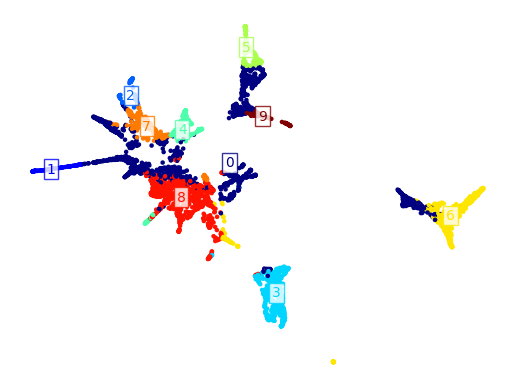

In [9]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP

# load all embeddings into memory
embedding_store = ve.EmbeddingData.load(save_path)

# reduce dimensionality using PCA
embeddings_pcs = PCA(n_components=20).fit_transform(embedding_store.embeddings)

# project into 2D with UMAP (for visualization purposes)
umap_coordinates = UMAP(n_components=2, n_neighbors=200).fit_transform(embeddings_pcs)

# cluster in PCA space (adjust n_clusters as desired)
kmeans_labels = KMeans(n_clusters=10).fit_predict(embeddings_pcs)

# save UMAP embedding and cluster labels
embedding_store.metadata[["UMAP x", "UMAP y"]] = umap_coordinates
embedding_store.metadata["kmeans"] = kmeans_labels
embedding_store.save(save_path) # overwrites existing file

# plot UMAP coordinates, colored by cluster
ve.scatter_with_cluster_labels(umap_coordinates, kmeans_labels);

### Inspect one cluster at a time

Play a random sample of clips from the chosen cluster. It may take several seconds for the videos to load.

In [11]:
cluster = 3
n_examples = 4

example_ixs = np.random.choice((clus==cluster).nonzero()[0], n_examples, replace=False)

example_clips = []
for ix in example_ixs:
    video_path, start_frame, end_frame = embedding_store.get_clip_info(ix)
    clip = ve.load_video_clip(video_path, start_frame, end_frame)
    example_clips.append(clip)
        
titles = [f"cluster {cluster}, example {i}" for i in range(1, n_examples+1)]
ve.play_videos(example_clips, rows=1, cols=n_examples, inches=2.5, titles=titles)

### Inspect all clusters

Play a random sample of clips from each cluster. It may take a minute or longer for all the videos to load.

In [6]:
n_examples = 4 # number of examples per cluster

titles = []
example_clips = []

for cluster in tqdm.tqdm(np.sort(np.unique(clus))):

    # skip a cluster if it has fewer than `n_examples` elements
    if (clus==cluster).sum() < n_examples:
        print(f"Skipping cluster {cluster}; not enough examples")
    
    # randomly sample embeddings from the cluster
    ixs = np.random.choice((clus==cluster).nonzero()[0], n_examples, replace=False)
    titles += [f"cluster {cluster}, example {i}" for i in range(1, n_examples+1)]

    # load corresponding video clips
    for ix in ixs:
        video_path, start_frame, end_frame = embedding_store.get_clip_info(ix)
        clip = ve.load_video_clip(video_path, start_frame, end_frame)
            example_clips.append(clip)
        
ve.play_videos(example_clips, rows=len(example_clips)//n_examples, cols=n_examples, inches=2.5, titles=titles)

100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.65it/s]


## 5. Embed full videos

The following code embeds full videos using a sliding window. The gap between successive window positions is controlled by `spacing`. The embeddings are stored in h5 files (one per video) as follows.
```
  training_dir (e.g. "2025_06_08-14_59_22")
  └──video_embeddings
     ├──video1.h5
     ├──video2.h5
     ⋮
```

In [ ]:
embedder = ve.VideoEmbedder.from_training_run(training_dir, device)
duration = embedder.duration
crop_size = embedder.crop_size
spacing = 15 # start a new clip every 0.5 seconds

embeddings_dir = os.path.join(training_dir, "video_embeddings")
os.makedirs(embeddings_dir, exist_ok=True)


for video_path, track in smooth_tracks.items():
    # compute embeddings
    streamer = ve.VideoClipStreamer(video_path, duration, spacing, crop_size, track)
    embeddings = [embedder(clip) for clip in tqdm.tqdm(streamer)]

    # save to h5 file (using EmbeddingStore class)
    metadata = pd.DataFrame({
        "video_path": [video_path]*len(streamer), 
        "start_frame": streamer.start_frames,
        "end_frame": streamer.end_frames
    })
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    save_path = os.path.join(embeddings_dir, save_name + ".h5")
    ve.EmbeddingStore(np.stack(embeddings), metadata).save(save_path)
    print(f"Saved embeddings for {video_path} to {save_path}")

